# Simulating SNe II discovered by LSST

### Modified from previous work done by Thomas de Jaeger in [de Jaeger et al. 2017](http://adsabs.harvard.edu/abs/2017ApJ...835..166D)

In [1]:
import math
from itertools import product
from scipy import integrate
from scipy import interpolate
from numpy import vectorize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 14

In [2]:
c_light=299792.458   # in km/s
c_AA=299792458*1.0e10# in AA/s
alpha_IMF=1.35       # Salpeter IMF: Salpeter et al. 1955 ApJ 121: 161
z_max=1.2            # input('Givea value of the maximum redshift used :')
z_sim=np.arange(0.01,z_max,0.01)
fow_LSST=9.62        # field of view LSST in degrees^2
delta_omega=fow_LSST*(math.pi/180)**2      # field of view LSST in str
# calculating for r-band -> http://smtn-002.lsst.io/en/latest/
h_erg = 6.63e-27     # Planck constant (erg.s)
h = 0.70             # dimensionless Hubble constant
H0 = 100.0 * h       # Hubble constant in Km/s/Mpc
d_h=c_light/H0   # Hubble distance in Mpc   (70 km/s / Mpc)

mag_lim={'u':23.60,'g':24.83,'r':24.38,'i':23.92,'z':23.35,'y':22.44} #mag lim 1 expo grizY
#mag_lim_10=[26.1,27.4,27.5,26.8,26.1,24.9]   #mag lim stacked images after 10 years

#cosmology
omega_m=0.30
omega_k=0.0
omega_lambda=0.70

In [3]:
def e_z_distri(z):
    return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))
    e_z_int, e_z_int_err = integrate.quad(e_z_distri,0.,z)

def r_com_distri(z):   ## dc in Pancho paper                # We define comoving distance for flat universe in Mpc
    return (d_h*integrate.quad(e_z_distri,0.,z)[0])

def d_lum_distri(z):                   # We define luminosity distance for flat universe in Mpc
    return (r_com_distri(z)*(1+z))

def d_mod_distri(z):                   # We define modulus distance for flat universe
    return (5.0 * np.log10(d_lum_distri(z)*10**6/10))

def madau_time(t):                   # We define t9 as Madeau et al 1998
    return (13*pow((1+t),-1.5))

def salpeter(M):
    return (pow(M,-(1+alpha_IMF)))
def Mass_tot(M):
    return (M*pow(M,-(1+alpha_IMF)))

a=3.4
b=-0.3
c=-3.5
ro=0.016*0.73
eta=-10
B=2**(1-a/b)
C=2**((b-a)/c)*5**(1-b/c)
def SFR_Horiuchi(z):
    return (ro*((1+z)**(a*eta)+((1+z)*1.0/B)**(b*eta)+((1+z)*1.0/C)**(c*eta))**(-0.1))
def SNR_Horiuchi(z):
    return (KII*SFR_Horiuchi(z))

a1=0.0166 
b1=0.1848 
c1=1.9474 
d1=2.6316 
def SFR_Cole(z):
    return (h*(a1+b1*z)/(1+(z/c1)**d1))
def SNR_Cole(z):
    return (KII*SFR_Cole(z))   

a2=0.015 
b2=2.7 
c2=2.9
d2=5.6 
def SFR_Madau(z):
    return (a2*((1+z)**b2/(1+((1+z)/c2)**d2)))
def SNR_Madau(z):
    return (KII*SFR_Madau(z)) 

def dust(z):
    if z<3.3:
        f_dust=0.95-0.28*z
    else:
        f_dust=0.02
    return f_dust 

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def e_z_LCDM(z):
    return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))
    e_z_int_LCDM, e_z_int_err_LCDM = integrate.quad(e_z_LCDM,0.,z)

def r_com_LCDM(z):                   # We define comoving distance for flat universe in Mpc
    return (d_h*integrate.quad(e_z_LCDM,0.,z)[0])

def d_lum_LCDM(z):                   # We define luminosity distance for flat universe in Mpc
    return (r_com_LCDM(z)*(1+z))

def mu_LCDM(z):                   # We define modulus distance for flat universe
    return (5.0 * np.log10(d_lum_LCDM(z)*10**6/10))

# 1. Preliminaries

## 1.1 LSST filter responses

We load the LSST filter throughputs from https://github.com/lsst/throughputs/tree/master/baseline

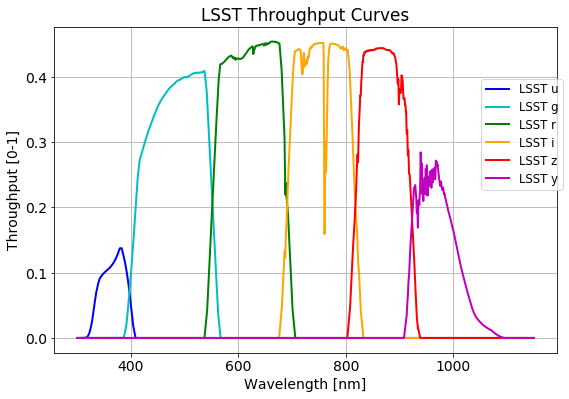

In [4]:
import lsst.sims.photUtils.Bandpass as Bandpass

lsst={}
x_func={}
s_x={}
dem_x={}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
lsst_effl={'u':3654.9,'g':4800.3,'r':6222.0,'i':7540.6,'z':8682.1,'y':9916.6}
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}

for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput('total_'+f+'.dat')

    trans_file=np.loadtxt('total_'+f+'.dat')
    lambda_filter=trans_file[:,0]*10     #in AA
    s_x[f]=trans_file[:,1]
    x_func[f]=interpolate.interp1d(lambda_filter,s_x[f])
    dem_x[f]=integrate.simps(x_func[f](lambda_filter)*1.0/lambda_filter,lambda_filter) 

    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))

plt.xlabel('Wavelength [nm]')
plt.ylabel('Throughput [0-1]')
plt.title('LSST Throughput Curves')
plt.legend(loc=(0.85, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.savefig(os.path.join('LSSTfilters.png'), format='png')
plt.show()

## 1.2 K-corrections

We use [Dessart et al. 2013](http://esoads.eso.org/abs/2013MNRAS.433.1745D) models to measure K-corrections between bands

In [5]:
class Kcorrection(object):
    def __init__(self):
        self.array = np.empty((len(filterlist),len(filterlist),len(z_sim)))
        self.interpolate ={}
    
    def __getitem__(self,(f1,f2,z)):
        return self.array[filterlist.index(f1),filterlist.index(f2),z]

    def __setitem__(self,(f1,f2,z),value):
        self.array[filterlist.index(f1),filterlist.index(f2),z]=value
    
    def interpol(self,f1,f2):
        if f1+f2 not in self.interpolate:
            self.interpolate[f1+f2]=interpolate.interp1d(z_sim,self[f1,f2,:])  
        return self.interpolate[f1+f2]

In [6]:
#take Dessart' model 50 days after explosion
ascii=pd.read_table('m15mlt3/m15_du_sch_mlt3_FeC_mix0p4_18.fl',delim_whitespace=True,header=None)
lambda_model=ascii[0].values
flux_model=ascii[1].values

F_spec_model_0=interpolate.interp1d(lambda_model,flux_model)

Kcor=Kcorrection()
m_lsst_za={}
m_lsst_0={}
            
for i,zs in enumerate(z_sim):
    lambda_model_obs=lambda_model*(1+zs)
    flux_model_obs=flux_model/(1+zs)
    F_spec_model_z=interpolate.interp1d(lambda_model_obs,flux_model_obs)
    
    for f in filterlist:
        #comparison of F_spec_model_z and F_spec_model_0
        n_lsst_za=integrate.simps(F_spec_model_z(lambda_filter)*x_func[f](lambda_filter)*lambda_filter,lambda_filter)   
        m_lsst_za[f]=-2.5*(np.log10(n_lsst_za/dem_x[f]))-48.60+2.5*(np.log10(c_AA))
        #Comparison of F_spec_model_z(SDSS) and F_spec_model_0(CSP)
        n_lsst_0=integrate.simps(F_spec_model_0(lambda_filter)*x_func[f](lambda_filter)*lambda_filter,lambda_filter)   
        m_lsst_0[f]=-2.5*(np.log10(n_lsst_0/dem_x[f]))-48.60+2.5*(np.log10(c_AA))

    for j,f1 in enumerate(filterlist):
        for k,f2 in enumerate(filterlist):
            Kcor[f1,f2,i]=m_lsst_za[f1]-m_lsst_0[f2]

## 1.3 Here we construct a K-correction term from all bands to r-band

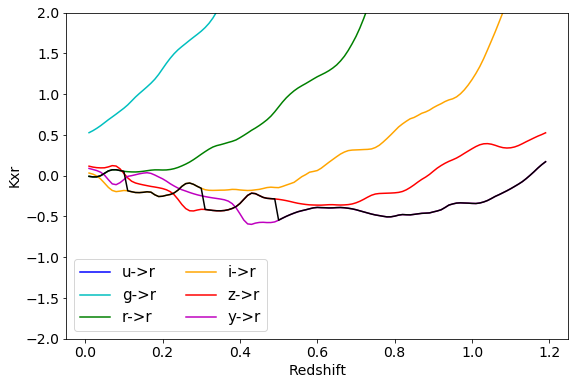

In [7]:
Kxr=np.zeros(len(z_sim))
for i,zs in enumerate(z_sim):
    #select the closest filter to r at a certain redshift
    lambda_eff=lsst_effl['r']*(1+zs)    
    ind_X = np.where(np.array(lsst_effl.values()) == find_nearest(lsst_effl.values(),lambda_eff) )[0][0]    
    Kxr[i]=Kcor[lsst_effl.keys()[ind_X],'r',i]

Kxr_func=interpolate.interp1d(z_sim,Kxr)

for j,f1 in enumerate(filterlist):
    plt.plot(z_sim,Kcor.interpol(f1,'r')(z_sim),filtercolors[f1])
plt.plot(z_sim,Kxr_func(z_sim),'black')
plt.xlabel('Redshift')
plt.ylabel('Kxr')
plt.ylim(-2,2)
plt.legend(('u->r','g->r','r->r','i->r','z->r','y->r'),loc=3,markerscale=0.5,prop={'size':15},ncol=2) 
plt.show()

#Final Kcorrections fron x to r in Kx_r and Kxr_func
# r->r if zs <= 0.105:
# i->r if zs > 0.105 and zs <= 0.303:
# z->r if zs > 0.303 and zs <= 0.494:
# y->r if zs > 0.494:

# 2. Calculating SNII rate

We will basically apply the approach by [Forster et al. 2006](http://adsabs.harvard.edu/abs/2006MNRAS.368.1893F)/[Strogler et al. 2004](http://adsabs.harvard.edu/abs/2004ApJ...613..200S) adapted to SNe II following [Botticella et al. 2012](http://adsabs.harvard.edu/abs/2012A%26A...537A.132B)


The rate of SNe II per unit time per unit comoving volume (RII) is given by the star formation rate (SFR) per unit time per unit comoving volume convolved with the number of stars crearted that will explode as SNe II (which we will estimate assuming a [Salpeter et al. (1955)](http://adsabs.harvard.edu/abs/1955ApJ...121..161S) IMF and their progenitors are stars from 8 to 25 solar masses).

<img src="img/snr_ii.png" alt="snr_ii" style="width: 150px;"/>

## 2.1 Calculating the fraction of stars that explode as SN II

<img src="img/fraction.png" alt="fraction" style="width: 180px;"/>

In [8]:
mass_min=8
mass_max=25

KII=integrate.quad(salpeter,mass_min,mass_max)[0]/(integrate.quad(Mass_tot,0.1,100.))[0]
print(KII)

0.00602707676336


## 2.2 Calculating SFR

As an example, we will use 3 different SFR evolutions with redshift: [Cole et al. (2001)](http://adsabs.harvard.edu/abs/2001MNRAS.326..255C), [Horiuchi et al. (2011)](http://adsabs.harvard.edu/abs/2011ApJ...738..154H), and [Madau et al. (2014)](http://adsabs.harvard.edu/abs/2014ARA%26A..52..415M)

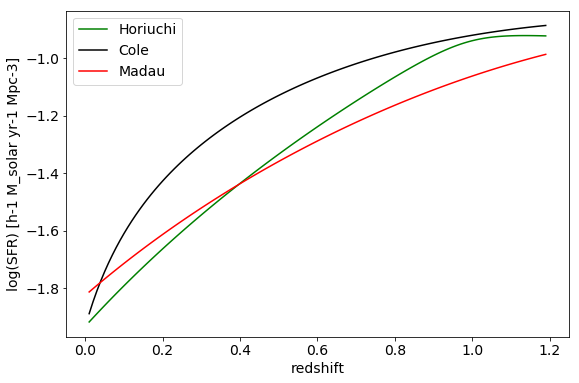

In [9]:
SFR_Horiuchi_vect=vectorize(SFR_Horiuchi)
SFR_Cole_vect=vectorize(SFR_Cole)
SFR_Madau_vect=vectorize(SFR_Madau)

plt.plot(z_sim,np.log10(SFR_Horiuchi_vect(z_sim)),'g',z_sim,np.log10(SFR_Cole_vect(z_sim)),'k',z_sim,np.log10(SFR_Madau_vect(z_sim)),'r')
plt.legend(('Horiuchi','Cole','Madau'))
plt.xlabel('redshift')
plt.ylabel('log(SFR) [h-1 M_solar yr-1 Mpc-3]')
plt.show()

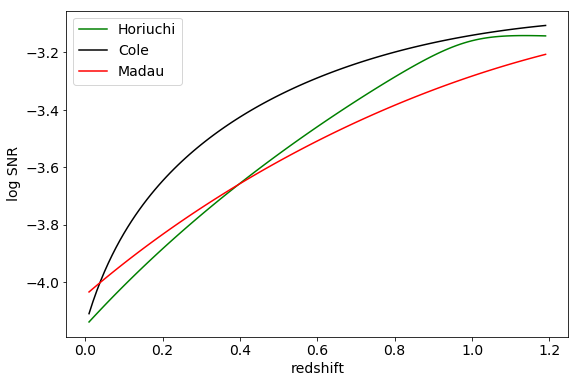

In [10]:
SNR_Horiuchi_vect=vectorize(SNR_Horiuchi)
SNR_Cole_vect=vectorize(SNR_Cole)
SNR_Madau_vect=vectorize(SNR_Madau)

plt.plot(z_sim,np.log10(SNR_Horiuchi_vect(z_sim)),'g',z_sim,np.log10(SNR_Cole_vect(z_sim)),'k',z_sim,np.log10(SNR_Madau_vect(z_sim)),'r')
plt.legend(('Horiuchi','Cole','Madau'))
plt.xlabel('redshift')
plt.ylabel('log SNR')
plt.show()

# 3. Example with SN II 2005J

## 3.1 At which redshift SN 2005J would not be detected with LSST?
We will first take SN II 2005J as a reference and assume that all SNe II are like 05J. We simulate its r-band light curve at different redshifts and see that at z=0.39 it would be below the LSST detections limit


Not visible from z=0.43


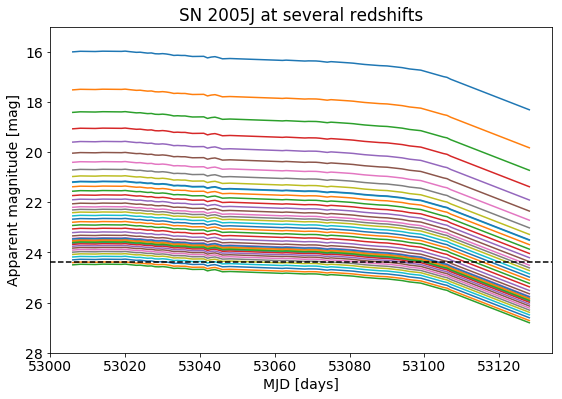

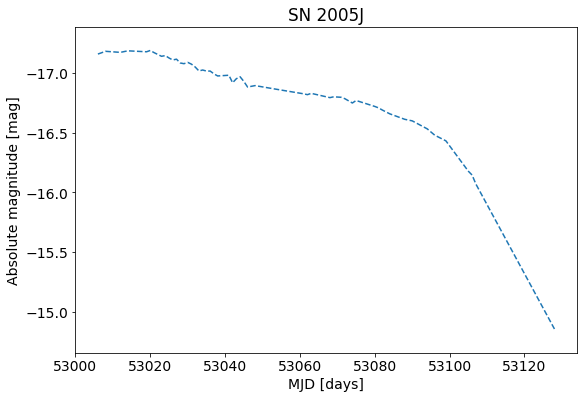

In [11]:
JD_explosion=2453382.78
JD_ref=2453000
z_cmb=4183./c_light
err_z_cmb=150./c_light

SN_photo=pd.read_table('05J/sn2005j.out_r_swope',delim_whitespace=True,header=None)
SN_epoch=SN_photo[0].values+JD_ref-JD_explosion
mag_r=SN_photo[1].values
dmag_r=SN_photo[2].values

M_SN_r=mag_r-5*np.log10(d_lum_distri(z_cmb))-25
dM_SN_r=np.sqrt(dmag_r**2+(np.array(err_z_cmb)*(5*(1+np.array(z_cmb))*1.0/(np.array(z_cmb)*(1+np.array(z_cmb)*1.0/2)*np.log10(10))))**2)

m_sn=np.zeros(shape=(len(SN_epoch),len(z_sim)))
for t,snep in enumerate(SN_epoch):
    for z,zs in enumerate(z_sim):
        m_sn[t,z]=M_SN_r[t]+d_mod_distri(zs)+Kxr_func(zs)
for z,zs in enumerate(z_sim):
    plt.plot(SN_epoch,m_sn[:,z]) 
    if min(m_sn[:,z]) > mag_lim['r']:
        print('Not visible from z='+str(zs))
        break
plt.ylim(28,15)
plt.axhline(mag_lim['r'], color='k', linestyle='--')
plt.xlabel('MJD [days]')
plt.ylabel('Apparent magnitude [mag]')
plt.title('SN 2005J at several redshifts')
plt.show()

plt.plot(SN_epoch,M_SN_r, linestyle='--') 
plt.ylim(np.max(M_SN_r)+0.2,np.min(M_SN_r)-0.2)
plt.title('SN 2005J')
plt.ylabel('Absolute magnitude [mag]')
plt.xlabel('MJD [days]')
plt.show()


## 3.2 How many SNe II (2005J-like) would the LSST discover in 1 year?

First, we compare our $m(t,z)$ with $m_{lim}$ of the LSST camera to obtain $\Delta_{t}(z)$,  the probability of detecting (the peak of) a SN at a given redshift 

In [ ]:
t_min=[0]*len(z_sim)
t_max=[0]*len(z_sim)
t_max_2=[0]*len(z_sim)
delta_t_redshift=[0]*len(z_sim) #delta t corrected by redshift
epoch_model_z=[0]*len(SN_epoch)

for i,zs in enumerate(z_sim):
    epoch_model_z=SN_epoch*(1+zs)  #1+z factor for time dilation
    if min(m_sn[:,i][:])<mag_lim['r']:
        t_min[i]=epoch_model_z[min(np.where(m_sn[:,i]<=mag_lim['r'])[0])]
        o=set(np.where(epoch_model_z>=t_min[i])[0])   #index of the last t>t_min
        p=set(np.where(m_sn[:,i]<=mag_lim['r'])[0])        #index at which we see the SN
        q=(list(o-p))                                 #all the indeces where we see the peak
        if q==[]:
            t_max[i]=epoch_model_z[max(np.where(m_sn[:,i]<=mag_lim['r'])[0])]
            delta_t_redshift[i]=t_max[i]-t_min[i]
        else:
            t_max[i]=epoch_model_z[min(q)]
            t_max_2[i]=epoch_model_z[max(q)]
            delta_t_redshift[i]=(t_max[i]-t_min[i])+(max(epoch_model_z)-t_max_2[i])#le SBO+ rest of curve

Now we estimate the number of detected SNe II per unit of redshift, $dN/dz$. From Equations 2 and 5 of Forster et al. (2006)

In [ ]:
dV_dz_dW=np.zeros(len(z_sim))

#############
survey_length=1.0   #in years
#############

dn_dz_Horiuchi=[0]*len(z_sim)   
dn_dz_Cole=[0]*len(z_sim)      
dn_dz_Madau=[0]*len(z_sim)      

for i,zs in enumerate(z_sim):
    dV_dz_dW[i]=(pow(r_com_distri(zs),2)*d_h*e_z_distri(zs))                 #dV(z) is the volume per unit redshift being surveyed

    #total observing time multiplied by the probability of detecting a SN
    dn_dz_Horiuchi[i]=SNR_Horiuchi(zs)/(1.+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)     #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=SNR_Cole(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)          #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]=SNR_Madau(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)        #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
                               
    
plt.plot(z_sim,dn_dz_Horiuchi,'b',z_sim,dn_dz_Cole,'c',z_sim,dn_dz_Madau,'r')
plt.title('The number of detected SNe II per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
for i,zs in enumerate(z_sim):
    if dn_dz_Horiuchi[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break
        
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))
for i,zs in enumerate(z_sim):
    if dn_dz_Cole[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break
        
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break


# 4. Example with a model of a 'typical' SN II

Instead of assuming that all SNe II are like SN 2005J, we will use the spectral model of [Dessart et al. (2013](http://adsabs.harvard.edu/abs/2013MNRAS.433.1745D) which is anchored to SN II 1999em. 

This SN is a bit fainter compared to SN 2005J ($M_{99em}=-16.6$; $M_{05J}=-17.2$), so we expect to find a distribution with a cutout at lower redshifts.

In [ ]:
##This loads all models in lam,flux_model
model=pd.read_table('m15mlt3/m15_du_sch_mlt3_FeC_mix0p4_list',delim_whitespace=True,header=None)
filename=model[0].values
epoch=model[1].values

lam_model=len(epoch)*[0]
flux_model=len(epoch)*[0]

puta99em=pd.read_table('sn1999em.out_R',delim_whitespace=True,header=None)
ep_99em=puta99em[0].values-51476.5
mag_99em=puta99em[1].values
F_99em=interpolate.interp1d(ep_99em,mag_99em)

mapp_99em=len(filename)*[0]
Mabs_99em=len(filename)*[0]
for i,fname in enumerate(filename):
    if i ==0:
        ascii=pd.read_table('m15mlt3/'+fname+'.fl',delim_whitespace=True,header=None)
        lam_model[i]=ascii[0].values
        flux_model[i]=ascii[1].values
        
        #mangling
        F_spec_model_z=interpolate.interp1d(lam_model[i]/1.002392,flux_model[i]*1.002392)
        n_obs=integrate.simps(F_spec_model_z(lambda_filter)*x_func['r'](lambda_filter)*lambda_filter,lambda_filter)
        m_obs_r=-2.5*np.log10(n_obs/dem_x['r'])-48.60+2.5*(np.log10(c_AA))
        factor=10**(-0.4*(F_99em(epoch[i])-m_obs_r))
                
    ascii=pd.read_table('m15mlt3/'+fname+'.fl',delim_whitespace=True,header=None)
    lam_model[i]=ascii[0].values
    flux_model[i]=ascii[1].values*factor
    
    F_spec_model_z=interpolate.interp1d(lam_model[i],flux_model[i])
    num=integrate.simps(F_spec_model_z(lambda_filter)*x_func['r'](lambda_filter)*lambda_filter,lambda_filter)
    mapp_99em[i]=-2.5*np.log10((num/dem_x['r']))-48.60+2.5*(np.log10(c_AA))
    Mabs_99em[i]=mapp_99em[i]-mu_LCDM(0.002392)

    plt.plot(lam_model[i],flux_model[i])

plt.xlim(1000,15000)
plt.show()

In [ ]:
m_sn_model=np.zeros(shape=(len(epoch),len(z_sim)))
for i,snep in enumerate(epoch):
    for t,zs in enumerate(z_sim):
        m_sn_model[i,t]=Mabs_99em[i]+d_mod_distri(zs)+Kxr_func(zs)

for i,zs in enumerate(z_sim):
    plt.plot(epoch,m_sn_model[:,i]) #M_SN_r,)#
    if min(m_sn[:,i]) > mag_lim['r']:
        print('Not visible from z='+str(zs))
        break
#plt.ylim(np.max(m_sn_model)+0.2,np.min(m_sn_model)-0.2)
plt.ylim(30,16)
plt.xlim(0.,450)
plt.axhline(mag_lim['r'], color='k', linestyle='--')
plt.xlabel('MJD [days]')
plt.ylabel('Apparent magnitude [mag]')
plt.title('Luc at several redshifts')
plt.show()

## 4.2 How many SNe II (Dessart-like) would the LSST discover in 1 year?

First, we compare our $m(t,z)$ with $m_{lim}$ of the LSST camera to obtain $\Delta_{t}(z)$,  the probability of detecting (the peak of) a SN at a given redshift 

In [ ]:
t_min=[0]*len(z_sim)
t_max=[0]*len(z_sim)
t_max_2=[0]*len(z_sim)
delta_t_redshift=[0]*len(z_sim) #delta t corrected by redshift
epoch_model_z=[0]*len(epoch)

for i,zs in enumerate(z_sim):
    epoch_model_z=epoch*(1+zs)  #1+z factor for time dilation
    if min(m_sn_model[:,i][:])<mag_lim['r']:
        t_min[i]=epoch_model_z[min(np.where(m_sn_model[:,i]<=mag_lim['r'])[0])]
        o=set(np.where(epoch_model_z>=t_min[i])[0])              #index of the last t>t_min
        p=set(np.where(m_sn_model[:,i]<=mag_lim['r'])[0])        #index at which we see the SN
        q=(list(o-p))                                            #all the indeces where we see the peak
        if q==[]:
            t_max[i]=epoch_model_z[max(np.where(m_sn_model[:,i]<=mag_lim['r'])[0])]
            delta_t_redshift[i]=t_max[i]-t_min[i]
        else:
            t_max[i]=epoch_model_z[min(q)]
            t_max_2[i]=epoch_model_z[max(q)]
            delta_t_redshift[i]=(t_max[i]-t_min[i])+(max(epoch_model_z)-t_max_2[i])

In [ ]:
dV_dz_dW=np.zeros(len(z_sim))

#############
survey_length=1.0   #in years
#############

dn_dz_Horiuchi=[0]*len(z_sim)   
dn_dz_Cole=[0]*len(z_sim)      
dn_dz_Madau=[0]*len(z_sim)      
for i,zs in enumerate(z_sim):
    dV_dz_dW[i]=(pow(r_com_distri(zs),2)*d_h*e_z_distri(zs))                 #dV(z) is the volume per unit redshift being surveyed

    dn_dz_Horiuchi[i]=SNR_Horiuchi(zs)/(1.+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)     #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=SNR_Cole(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)          #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]=SNR_Madau(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)        #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view                               
    
plt.plot(z_sim,dn_dz_Horiuchi,'b',z_sim,dn_dz_Cole,'c',z_sim,dn_dz_Madau,'r')
plt.title('The number of detected SNe II per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
for i,zs in enumerate(z_sim):
    if dn_dz_Horiuchi[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break
        
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))
for i,zs in enumerate(z_sim):
    if dn_dz_Cole[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break
        
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break


# 5. Example with a CSP-like simulated sample of SNe II

Finally, we will use a a sample of 10,000 SNe, simulated using MCMC on real parameters of CSP SNe II. We will put each at 100 random redshifts form 0.01 to 1.20, so we will have 1,000,000 SNe.

Note that what we also change here is that we will consider the magnitude at the end of the plateau phase. This is becuase in SNII cosmology, we do not standardize the magnitude at peak but either the magnitude at around the center of the plateau (for spectroscopic methods), or the length/brightness-decline of the plateu (for photometric methods).

In [ ]:
survey_length=1.0

##simulation file:
MC_var=np.loadtxt('mc_var.dat').transpose()

Mabs_V_MC=MC_var[0] #M at the end of the plateau
s2_MC=MC_var[1]     #slope of the plateau
B_V_MC=MC_var[2]    #color at the end of the plateau
Pd_MC=MC_var[3]     #plateau duration

In [ ]:
#we will put these 1000 SNe at a random redshifts

N_SNe=len(Mabs_V_MC)

z_random=np.sort(np.random.random(100)*max(z_sim-0.04)+0.04)

m_SN=np.zeros((N_SNe,len(z_random)))
Pd_SN=np.zeros((N_SNe,len(z_random)))
delta_t_SN=np.zeros((N_SNe,len(z_random)))

for i,zs in enumerate(z_random):
    m_SN[:,i]=mu_LCDM(zs)+Mabs_V_MC+Kxr_func(zs)
    Pd_SN[:,i]=Pd_MC*(1+zs)

This is how the 'distribution' of apparent magnitudes AT THE END OF THE PLATEAU PHASE for the first 2000 (over 1.000,000) SNe II look at differnet redshifts. 

Those 'jumps' happen at redshifts where the best K-correction changes the observed filter.

In [ ]:
for i in range(2000):
    plt.plot(z_random,m_SN[i,:],alpha=0.9,linewidth=0.1,color='b')
plt.xlabel('z')
plt.ylabel('m$_{end}$')
plt.ylim(30,18)
plt.show()

Here we measure $\Delta_t(z)$, selecting different magnitude limit depending on the filter we use for observations.

In [ ]:
for j in range((N_SNe)):
    for i in range(len(z_random)):
        if z_random[i]<=0.3:           #V_swope would be converted to r_LSST                       
            if m_SN[j,i]<mag_lim['r']:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.3) and (z_random[i]<=0.57) :  #V_swope would be i_LSST
            if m_SN[j,i]<mag_lim['i']:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.57) and (z_random[i]<=0.78) : #V_swope would be z_LSST
            if m_SN[j,i]<mag_lim['z']:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.78) :      #V_swope would be y_LSST
            if m_SN[j,i]<mag_lim['y']:
                delta_t_SN[j,i]=Pd_SN[j,i]

NOTE: this may be improved by carrying the distribution of delta_t_SN at each redshift, instead of simply measuring the average at each redshift

In [ ]:
delta_t_SN_tot=np.zeros((len(z_random)))
for i in range(len(z_random)):
    delta_t_SN_tot[i]=sum(delta_t_SN[:,i])

delta_t_SN_tot=delta_t_SN_tot/N_SNe

In [ ]:
dV_dz_dW=np.zeros(len(z_random))

dn_dz_Horiuchi=np.zeros(len(z_random)) 
dn_dz_Cole=np.zeros(len(z_random))
dn_dz_Madau=np.zeros(len(z_random))

for i in range(len(z_random)):
    dV_dz_dW[i]=(pow(r_com_LCDM(z_random[i]),2)*d_h*e_z_LCDM(z_random[i]))    #dV(z) is the volume per unit redshift being surveyed

    dn_dz_Horiuchi[i]=SNR_Horiuchi(z_random[i])/(1+z_random[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]    =SNR_Cole(z_random[i])    /(1+z_random[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]   =SNR_Madau(z_random[i])   /(1+z_random[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view                               

z_random,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau = zip(*sorted(zip(z_random,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau)))

plt.plot(z_random,np.array(dn_dz_Cole),'c',z_random,np.array(dn_dz_Horiuchi),'b',z_random,np.array(dn_dz_Madau),'r')
plt.title('The number of detected SNe II per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))    
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
z_tot_Madau=[]
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe II from z='+str(zs))
        break

z_random,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau = zip(*sorted(zip(z_random,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau)))
z_tot_Madau=[]
for i,zs in enumerate(z_random):
    for j in range((int(round(dn_dz_Madau[i],0)))):
        z_tot_Madau.append(zs)

We have found the shape of the distribution, below one can create the final distribution by giving the total number of SNe II (with no selection effects) that LSST is supposed to found

In [ ]:
N_SNe_HD=input("Number of SNe for the Hubble diagram: ")
z_SNe_HD=np.random.choice(z_tot_Madau, N_SNe_HD, replace=True)

plt.hist(z_SNe_HD,color='blue',alpha=0.9,label='Single-visit')
plt.legend(loc=1,markerscale=0.5,prop={'size':12},ncol=2)
#plt.xlim(0,1.2)
plt.xlabel('redshift')
plt.ylabel('SN ')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.savefig('LSST_distribution.png')
plt.show()
